# Classify Candidate Pairs of Acronyms and Expansions (Assignment 2)

## 1. Import Library

In [ ]:
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from datasets import Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import time
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import seaborn as sns
#from torch.utils.data import Dataset, DataLoader

## 2. Prepare Dataset

### 2.1 extract dataset

In [5]:
with tarfile.open("dataacro.tar.gz", "r:gz") as tar:
    tar.extractall("dataacro")

### 2.2 Load dataset

#### 2.2.1 Define extract dataset function

In [5]:
def extract_feature(list_doc):
    X=[]
    y=[]
    for i in range(len(list_doc)):
        lines_feature=list_doc[i].split(" ")[-8:len(list_doc[i])]
        line_label=list_doc[i].split(" ")[-9]
        list_features=[float(line.strip().split(":")[1]) for line in lines_feature]
        list_label=int(line_label) 
        X.append(list_features)
        y.append(list_label)
    
    return X,y  

def extract_text(list_doc):
    X=[]
    y=[]
    for line in list_doc:
        text_feature=line.split(" ")[:-9]
        text_feature=" ".join(text_feature)
        line_label=line.split(" ")[-9]
        
        X.append(text_feature)
        y.append(line_label)
    
    return X

#### 2.2.2 Load and Preprocessing Data

In [6]:


with open("dataacro/trainingset.txt", "r") as file:
    training_lines = file.readlines()

with open("dataacro/testingset.txt", "r") as file:
    testing_lines = file.readlines()

  


X_train,y_train=extract_feature(training_lines)
X_test,y_test=extract_feature(testing_lines)   

X_train=np.array(X_train)
y_train=np.array(y_train)


X_test=np.array(X_test)
y_test=np.array(y_test)

#replace -1 with 0
y_train = np.where(y_train == -1, 0, y_train)
y_test = np.where(y_test == -1, 0, y_test)



X_train_text= extract_text(training_lines)
X_train_text=np.array(X_train_text)
X_train_text=X_train_text.reshape(-1,1)
X_test_text=extract_text(testing_lines)
X_test_text=np.array(X_test_text)
X_test_text=X_test_text.reshape(-1,1)
#check data length
print("Training data length: ", len(X_train))
print("Training data text length: ", len(X_train_text))
print("Training label length: ", len(y_train))
print("Testing data length: ", len(X_test))
print("Testing data text length: ", len(X_test_text))
print("Testing label length: ", len(y_test))


Training data length:  4000
Training data text length:  4000
Training label length:  4000
Testing data length:  1099
Testing data text length:  1099
Testing label length:  1099


#### 2.2.3 Describe Data

In [7]:
col_name=['F'+str(i+1) for i in range(X_train.shape[1])]
df_train=pd.concat([pd.DataFrame(X_train,columns=col_name),pd.DataFrame(y_train,columns=['label'])],axis=1)

print(df_train.head().to_markdown())

|    |       F1 |       F2 |        F3 |   F4 |   F5 |       F6 |   F7 |        F8 |   label |
|---:|---------:|---------:|----------:|-----:|-----:|---------:|-----:|----------:|--------:|
|  0 | 0.918296 | 1        | -0.666667 |  0   | 1    | 0.5      |    0 | 0.39309   |       0 |
|  1 | 1        | 0.5      | -2        |  0   | 0.75 | 0        |    0 | 0.0357143 |       0 |
|  2 | 0.970951 | 1        | -1        |  0.5 | 1    | 0.333333 |    0 | 0.400612  |       0 |
|  3 | 1        | 0.75     | -2        |  0   | 1    | 1        |    1 | 0.392857  |       0 |
|  4 | 0.970951 | 0.666667 | -2.5      |  0   | 1    | 0        |    0 | 0.0196596 |       0 |


In [8]:
col_name=['Fitur text']
df_train_text=pd.concat([pd.DataFrame(X_train_text,columns=col_name),pd.DataFrame(y_train,columns=['label'])],axis=1)

print(df_train_text.head().to_markdown())

|    | Fitur text                       |   label |
|---:|:---------------------------------|--------:|
|  0 | BUMD=>Usaha Milik                |       0 |
|  1 | TNI=>meminjam senjata dari oknum |       0 |
|  2 | PKI=>Panitia Pengawas            |       0 |
|  3 | MA=>putusan Mahkamah             |       0 |
|  4 | TI=>com Mati body                |       0 |


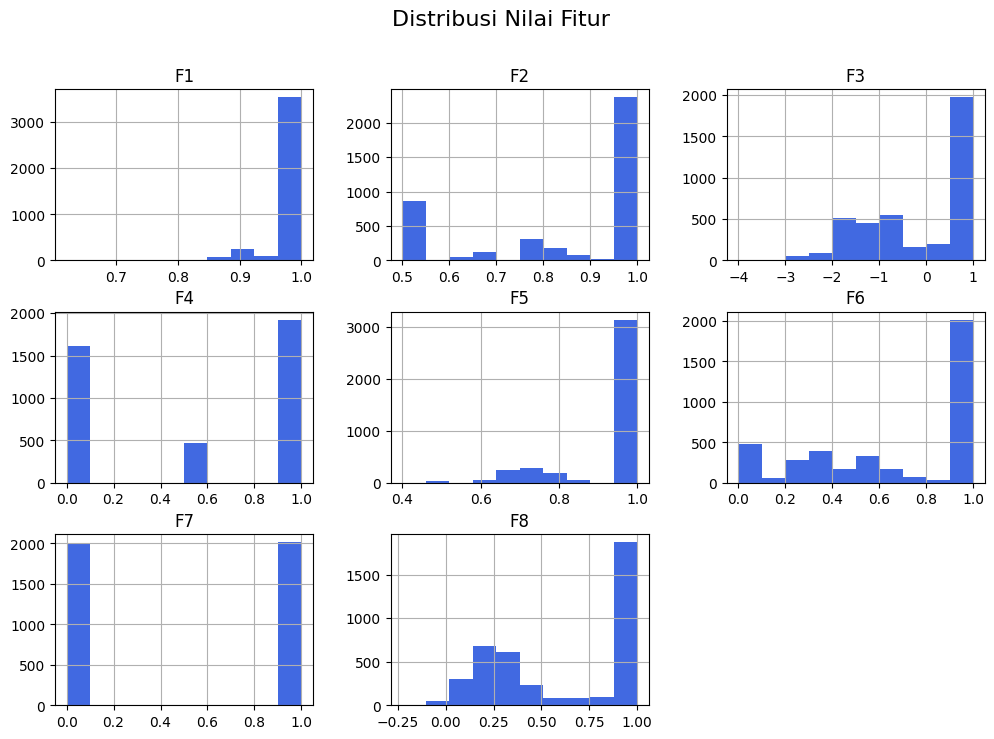

In [9]:
df_train.drop(columns=['label']).hist(figsize=(12, 8), bins=10, color='royalblue')
plt.suptitle("Distribusi Nilai Fitur ", fontsize=16)
plt.show()

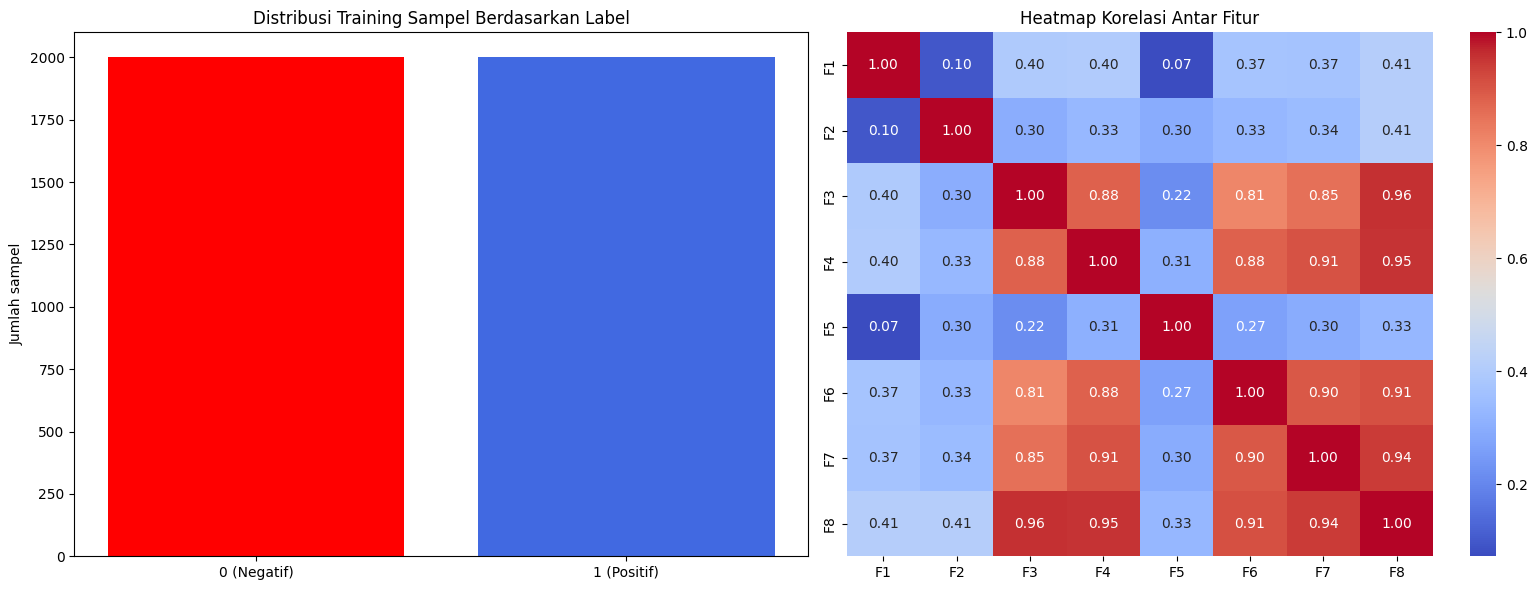

In [13]:
# Calculate label counts for the bar plot
label_count = df_train['label'].value_counts()

# Create a figure with two subplots in a single row
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns, adjust figsize for better spacing

# First subplot: Bar plot for label distribution
axes[0].bar(label_count.index, label_count.values, color=['red', 'royalblue'])
axes[0].set_ylabel("Jumlah sampel")
axes[0].set_title("Distribusi Training Sampel Berdasarkan Label")
axes[0].set_xticks([0, 1])  # Explicitly set tick positions
axes[0].set_xticklabels(["0 (Negatif)", "1 (Positif)"])  # Set tick labels manually

# Second subplot: Heatmap for feature correlation
sns.heatmap(df_train.drop(columns=['label']).corr(), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
axes[1].set_title('Heatmap Korelasi Antar Fitur')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the combined plot
plt.show()

## 3. Build Model - Supervised Learning

In [51]:
eval_model_df_training=pd.DataFrame()
eval_model_df_testing=pd.DataFrame()
eval_model_time=pd.DataFrame()

def input_model_result(df,y_true,y_pred,model_name):
    cm=confusion_matrix(y_true,y_pred)
    tn, fp, fn, tp = cm.ravel()
    pre=precision_score(y_true,y_pred)
    rec=recall_score(y_true,y_pred)
    f1=f1_score(y_true,y_pred)
    
    data={
            'Model':model_name,
            "Confusion Matrix": cm.tolist(),
            "TP": tp, "FP": fp, "FN": fn, "TN": tn,# Convert to list to avoid issues
            "Precision": pre,
            "Recall": rec,
            "F1-Score": f1,

        }
    if df.empty:
        df = pd.DataFrame([data])
    else:

        if model_name in df['Model'].values:
            print("Model already exists in the dataframe")
        else:
            df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)
        
            print(f"added new result for model: {model_name} ")
    return df

def input_train_test_time(df,tr_time,pred_time,model_name):
        data={
            'Model':model_name,
            "Training_time":tr_time,
            "Predict_time":pred_time
        }
        if df.empty:
            df = pd.DataFrame([data])
        else:

            if model_name in df['Model'].values:
                print("Model already exists in the dataframe")
            else:
                df = pd.concat([df, pd.DataFrame([data])], ignore_index=True)
            
                print(f"added new time_result for model: {model_name} ")
        return df
    

### 3.1 SVM Classifier

In [ ]:
svm = SVC(random_state=0)

x = [100.0,500.0,1000]
y = [0.1,0.2,0.3]
z = [2,3]    
parameters=[#{'C': x,'kernel': ['linear']},
            #{'C': x,'kernel': ['rbf'],'gamma': y} ,
            {'C': x,'kernel': ['poly'],'gamma': y,'degree': z}
           ]
grid=GridSearchCV(estimator = svm,
                        param_grid = parameters,
                        scoring='f1',
                        cv=10,
                        n_jobs=-1)
start_tm=time.time()
grid=grid.fit(X_train,y_train)
finish_tm=time.time()
training_time = finish_tm - start_tm
svm= grid.best_estimator_
best_params=grid.best_params_
best_score=grid.best_score_


print(f"Training Time: {training_time:.4f} seconds")
print(f"The best parameters are {grid.best_params_} with" +
          f"a score of {grid.best_score_:.2f}")

#The best parameters are {'C': 500.0, 'degree': 2, 'gamma': 0.2, 'kernel': 'poly'} witha score of 0.99

Training Time: 9.7246 seconds
The best parameters are {'C': 500.0, 'degree': 2, 'gamma': 0.2, 'kernel': 'poly'} witha score of 0.99


In [96]:
model_name='SVM '

start_tm=time.time()
y_pred_train= svm.predict(X_train)
finish_tm=time.time()
pred_train_time=finish_tm - start_tm


y_pred_test= svm.predict(X_test)

#input to eval table
eval_model_df_testing = input_model_result(eval_model_df_testing, y_test, y_pred_test,model_name=model_name)
eval_model_df_training= input_model_result(eval_model_df_training, y_train, y_pred_train,model_name=model_name)
eval_model_time=input_train_test_time(eval_model_time,training_time,pred_train_time,model_name)

added new result for model: SVM  
added new result for model: SVM  
added new time_result for model: SVM  


In [32]:
eval_model_df_training

,Model,Confusion Matrix,TP,FP,FN,TN,Precision,Recall,F1-Score
0,Support Vector Machine (SVM),"[[1961, 39], [13, 1987]]",1987,39,13,1961,0.98075,0.9935,0.987084


### 3.2 KNN Classifier 

In [50]:
## build model
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(2, 10)}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(knn, param_grid=param_grid,scoring="f1",cv=cv)

start_tm=time.time()
grid=grid.fit(X_train,y_train)
finish_tm=time.time()
training_time = finish_tm - start_tm

print(f"Training Time: {training_time:.4f} seconds")
print(f"The best parameters are {grid.best_params_} with" +
          f" f1-score of {grid.best_score_:.2f}")

knn = grid.best_estimator_


Training Time: 1.2790 seconds
The best parameters are {'n_neighbors': np.int64(9)} with f1-score of 0.71


In [52]:
model_name='K-Nearest Neighbor (kNN) '

start_tm=time.time()
y_pred_train= knn.predict(X_train)
finish_tm=time.time()
pred_train_time=finish_tm - start_tm


y_pred_test= knn.predict(X_test)

#input to eval table
eval_model_df_testing = input_model_result(eval_model_df_testing, y_test, y_pred_test,model_name=model_name)
eval_model_df_training= input_model_result(eval_model_df_training, y_train, y_pred_train,model_name=model_name)
eval_model_time=input_train_test_time(eval_model_time,training_time,pred_train_time,model_name)

In [54]:
eval_model_df_training

,Model,Confusion Matrix,TP,FP,FN,TN,Precision,Recall,F1-Score
0,K-Nearest Neighbor (kNN),"[[1967, 33], [1232, 768]]",768,33,1232,1967,0.958801,0.384,0.548376


### 3.3 Naive Bayes Classifier 

In [56]:
nb=GaussianNB()
start_tm=time.time()
nb.fit(X_train,y_train)
finish_tm=time.time()
training_time = finish_tm - start_tm

print(f"Training Time: {training_time:.4f} seconds")


Training Time: 0.0020 seconds


In [57]:
model_name='Naive Bayes '

start_tm=time.time()
y_pred_train= nb.predict(X_train)
finish_tm=time.time()
pred_train_time=finish_tm - start_tm


y_pred_test= nb.predict(X_test)

#input to eval table
eval_model_df_testing = input_model_result(eval_model_df_testing, y_test, y_pred_test,model_name=model_name)
eval_model_df_training= input_model_result(eval_model_df_training, y_train, y_pred_train,model_name=model_name)
eval_model_time=input_train_test_time(eval_model_time,training_time,pred_train_time,model_name)

added new result for model: Naive Bayes  
added new result for model: Naive Bayes  
added new time_result for model: Naive Bayes  


### 3.4 Decision Tree

In [ ]:
dt=tree.DecisionTreeClassifier()
param_grid = {
    "max_depth": [3, 5, 10, None],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 5],  
    "criterion": ["gini", "entropy"]
}

grid = GridSearchCV(dt, param_grid, cv=19, scoring="f1", n_jobs=-1)
start_tm=time.time()
grid=grid.fit(X_train,y_train)
finish_tm=time.time()
training_time = finish_tm - start_tm
dt = grid.best_estimator_

print(f"Training Time: {training_time:.4f} seconds")
print(f"The best parameters are {grid.best_params_} with" +
          f" f1-score of {grid.best_score_:.2f}")

Training Time: 0.3248 seconds
The best parameters are {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2} with f1-score of 0.99


In [63]:
model_name='Decision Tree '

start_tm=time.time()
y_pred_train= dt.predict(X_train)
finish_tm=time.time()
pred_train_time=finish_tm - start_tm


y_pred_test= dt.predict(X_test)

#input to eval table
eval_model_df_testing = input_model_result(eval_model_df_testing, y_test, y_pred_test,model_name=model_name)
eval_model_df_training= input_model_result(eval_model_df_training, y_train, y_pred_train,model_name=model_name)
eval_model_time=input_train_test_time(eval_model_time,training_time,pred_train_time,model_name)

added new result for model: Decision Tree  
added new result for model: Decision Tree  
added new time_result for model: Decision Tree  


## 4. Build Model - BERT

### 4.1 Penyiapan Dataset dan Tokenisasi

In [84]:
# Flatten the list of lists and join them into a list of strings
X_train_flat = [" ".join(item) for item in X_train_text]
X_test_flat = [" ".join(item) for item in X_test_text]
y_train_t=torch.tensor(y_train)
y_test_t=torch.tensor(y_test)
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text data, ensure padding and truncation for uniform length
tokenized_data = tokenizer(X_train_flat, padding=True, truncation=True, return_tensors="pt")
tokenized_test_data = tokenizer(X_test_flat, padding=True, truncation=True, return_tensors="pt")
# Inspect tokenized data (input_ids and attention_mask)
print(tokenized_data['input_ids'].shape)
print(tokenized_data['attention_mask'].shape)

train_dataset = Dataset.from_dict({
    'input_ids': tokenized_data['input_ids'],
    'attention_mask': tokenized_data['attention_mask'],
    'labels': y_train_t
})

test_dataset = Dataset.from_dict({
    'input_ids': tokenized_test_data['input_ids'],
    'attention_mask': tokenized_test_data['attention_mask'],
    'labels': y_test_t  # Labels for test data
})

# Verify the structure
print(train_dataset[0])

torch.Size([4000, 32])
torch.Size([4000, 32])
{'input_ids': [101, 26352, 2094, 1027, 1028, 3915, 3270, 23689, 5480, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}


### 4.2 Inisiasi Model

In [85]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.3 Penyiapan Trainer dan Melatih Model

In [86]:
training_args = TrainingArguments(
    output_dir="./results",      
    num_train_epochs=3,          
    per_device_train_batch_size=8,  
    per_device_eval_batch_size=8,  
    warmup_steps=500,            
    weight_decay=0.01,           
    logging_dir="./logs",        
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch"
)

bert = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer
)

start_tm=time.time()
bert.train()
finish_tm=time.time()
training_time = finish_tm - start_tm

print(f"Training Time: {training_time:.4f} seconds")

c:\Users\Najwan\miniconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\Najwan\AppData\Local\Temp\ipykernel_11920\1794867259.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bert = Trainer(


  0%|          | 0/1500 [00:00<?, ?it/s]

{'loss': 0.7118, 'grad_norm': 3.385584592819214, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.02}
{'loss': 0.752, 'grad_norm': 8.507855415344238, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.04}
{'loss': 0.7197, 'grad_norm': 8.07103443145752, 'learning_rate': 3e-06, 'epoch': 0.06}
{'loss': 0.6886, 'grad_norm': 3.3912525177001953, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.08}
{'loss': 0.6719, 'grad_norm': 4.134318828582764, 'learning_rate': 5e-06, 'epoch': 0.1}
{'loss': 0.7032, 'grad_norm': 3.7122936248779297, 'learning_rate': 6e-06, 'epoch': 0.12}
{'loss': 0.6939, 'grad_norm': 4.461877346038818, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.14}
{'loss': 0.6985, 'grad_norm': 7.539129734039307, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.16}
{'loss': 0.6743, 'grad_norm': 8.642992973327637, 'learning_rate': 9e-06, 'epoch': 0.18}
{'loss': 0.6601, 'grad_norm': 8.059813499450684, 'learning_rate': 1e-05, 'epoch': 0.2}
{'loss': 0.6861, 'grad_norm': 8.51693534

  0%|          | 0/138 [00:00<?, ?it/s]

{'eval_loss': 1.027740716934204, 'eval_runtime': 9.0126, 'eval_samples_per_second': 121.94, 'eval_steps_per_second': 15.312, 'epoch': 1.0}
{'loss': 0.1879, 'grad_norm': 87.7505111694336, 'learning_rate': 4.9500000000000004e-05, 'epoch': 1.02}
{'loss': 0.1181, 'grad_norm': 0.1850026398897171, 'learning_rate': 4.9e-05, 'epoch': 1.04}
{'loss': 0.3287, 'grad_norm': 12.74843978881836, 'learning_rate': 4.85e-05, 'epoch': 1.06}
{'loss': 0.2757, 'grad_norm': 8.986218452453613, 'learning_rate': 4.8e-05, 'epoch': 1.08}
{'loss': 0.174, 'grad_norm': 3.8822269439697266, 'learning_rate': 4.75e-05, 'epoch': 1.1}
{'loss': 0.2596, 'grad_norm': 0.1272934079170227, 'learning_rate': 4.7e-05, 'epoch': 1.12}
{'loss': 0.5462, 'grad_norm': 2.107450008392334, 'learning_rate': 4.6500000000000005e-05, 'epoch': 1.14}
{'loss': 0.1115, 'grad_norm': 0.24286557734012604, 'learning_rate': 4.600000000000001e-05, 'epoch': 1.16}
{'loss': 0.3441, 'grad_norm': 18.463790893554688, 'learning_rate': 4.55e-05, 'epoch': 1.18}
{

  0%|          | 0/138 [00:00<?, ?it/s]

{'eval_loss': 0.9373782873153687, 'eval_runtime': 8.9958, 'eval_samples_per_second': 122.168, 'eval_steps_per_second': 15.34, 'epoch': 2.0}
{'loss': 0.0645, 'grad_norm': 0.023603620007634163, 'learning_rate': 2.45e-05, 'epoch': 2.02}
{'loss': 0.0746, 'grad_norm': 1.3115837574005127, 'learning_rate': 2.4e-05, 'epoch': 2.04}
{'loss': 0.0013, 'grad_norm': 0.176570862531662, 'learning_rate': 2.35e-05, 'epoch': 2.06}
{'loss': 0.1281, 'grad_norm': 13.701517105102539, 'learning_rate': 2.3000000000000003e-05, 'epoch': 2.08}
{'loss': 0.0546, 'grad_norm': 10.838424682617188, 'learning_rate': 2.25e-05, 'epoch': 2.1}
{'loss': 0.0989, 'grad_norm': 191.8440399169922, 'learning_rate': 2.2000000000000003e-05, 'epoch': 2.12}
{'loss': 0.0018, 'grad_norm': 0.1621282398700714, 'learning_rate': 2.15e-05, 'epoch': 2.14}
{'loss': 0.0712, 'grad_norm': 7.102508544921875, 'learning_rate': 2.1e-05, 'epoch': 2.16}
{'loss': 0.1159, 'grad_norm': 0.2157527655363083, 'learning_rate': 2.05e-05, 'epoch': 2.18}
{'loss':

  0%|          | 0/138 [00:00<?, ?it/s]

{'eval_loss': 1.348976969718933, 'eval_runtime': 9.2387, 'eval_samples_per_second': 118.956, 'eval_steps_per_second': 14.937, 'epoch': 3.0}
{'train_runtime': 286.2511, 'train_samples_per_second': 41.921, 'train_steps_per_second': 5.24, 'train_loss': 0.24973365316602092, 'epoch': 3.0}
Training Time: 286.6905 seconds


In [90]:
# Save the fine-tuned model
save_path = "./saved_bert_model"
bert.save_model(save_path)
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model saved to {save_path}")

Model saved to ./saved_bert_model


In [92]:
model_name='BERT '

start_tm=time.time()
prediction_train=bert.predict(train_dataset)
y_pred_train=np.argmax(prediction_train.predictions, axis=1)
finish_tm=time.time()
pred_train_time=finish_tm - start_tm


prediction_test=bert.predict(test_dataset)
y_pred_test= np.argmax(prediction_test.predictions, axis=1)

#input to eval table
eval_model_df_testing = input_model_result(eval_model_df_testing, y_test, y_pred_test,model_name=model_name)
eval_model_df_training= input_model_result(eval_model_df_training, y_train, y_pred_train,model_name=model_name)
eval_model_time=input_train_test_time(eval_model_time,training_time,pred_train_time,model_name)

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/138 [00:00<?, ?it/s]

added new result for model: BERT  
added new result for model: BERT  
added new time_result for model: BERT  


## 5. Result And Evaluation

### 5.1 Training Result

In [101]:
print(eval_model_df_training.to_markdown())

|    | Model                    | Confusion Matrix          |   TP |   FP |   FN |   TN |   Precision |   Recall |   F1-Score |
|---:|:-------------------------|:--------------------------|-----:|-----:|-----:|-----:|------------:|---------:|-----------:|
|  0 | K-Nearest Neighbor (kNN) | [[1967, 33], [1232, 768]] |  768 |   33 | 1232 | 1967 |    0.958801 |   0.384  |   0.548376 |
|  1 | Naive Bayes              | [[1968, 32], [73, 1927]]  | 1927 |   32 |   73 | 1968 |    0.983665 |   0.9635 |   0.973478 |
|  2 | Decision Tree            | [[1961, 39], [11, 1989]]  | 1989 |   39 |   11 | 1961 |    0.980769 |   0.9945 |   0.987587 |
|  3 | BERT                     | [[1993, 7], [16, 1984]]   | 1984 |    7 |   16 | 1993 |    0.996484 |   0.992  |   0.994237 |
|  4 | SVM                      | [[1961, 39], [13, 1987]]  | 1987 |   39 |   13 | 1961 |    0.98075  |   0.9935 |   0.987084 |


In [102]:
print(eval_model_time.to_markdown())

|    | Model                    |   Training_time |   Predict_time |
|---:|:-------------------------|----------------:|---------------:|
|  0 | K-Nearest Neighbor (kNN) |      1.27896    |     0.163998   |
|  1 | Naive Bayes              |      0.00200081 |     0.00100636 |
|  2 | Decision Tree            |      0.324775   |     0.00100446 |
|  3 | BERT                     |    286.69       |    17.757      |
|  4 | SVM                      |      9.72459    |     0.0090909  |


### 5.2 Testing Result

In [100]:
print(eval_model_df_testing.to_markdown())

|    | Model                    | Confusion Matrix       |   TP |   FP |   FN |   TN |   Precision |   Recall |   F1-Score |
|---:|:-------------------------|:-----------------------|-----:|-----:|-----:|-----:|------------:|---------:|-----------:|
|  0 | K-Nearest Neighbor (kNN) | [[498, 2], [294, 305]] |  305 |    2 |  294 |  498 |    0.993485 | 0.509182 |   0.673289 |
|  1 | Naive Bayes              | [[500, 0], [66, 533]]  |  533 |    0 |   66 |  500 |    1        | 0.889816 |   0.941696 |
|  2 | Decision Tree            | [[496, 4], [45, 554]]  |  554 |    4 |   45 |  496 |    0.992832 | 0.924875 |   0.957649 |
|  3 | BERT                     | [[267, 233], [8, 591]] |  591 |  233 |    8 |  267 |    0.717233 | 0.986644 |   0.830639 |
|  4 | SVM                      | [[498, 2], [29, 570]]  |  570 |    2 |   29 |  498 |    0.996503 | 0.951586 |   0.973527 |


In [6]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
# Creating the test data evaluation DataFrame
test_data_eval = pd.DataFrame({
    "Model": ["Support Vector Machine (SVM)", "K-Nearest Neighbor (KNN)", "Naive Bayes", "Decision Tree", "BERT"],
    "Confusion Matrix": [
        [[498, 2], [29, 570]],
        [[498, 2], [294, 305]],
        [[500, 0], [66, 533]],
        [[496, 4], [45, 554]],
        [[267, 233], [8, 591]]
    ],
    "TP": [570, 305, 533, 554, 591],
    "FP": [2, 2, 0, 4, 233],
    "FN": [29, 294, 66, 45, 8],
    "TN": [498, 498, 500, 496, 267],
    "Precision": [0.996503, 0.993485, 1, 0.992832, 0.717233],
    "Recall": [0.951586, 0.509182, 0.889816, 0.924875, 0.986644],
    "F1-Score": [0.973527, 0.673289, 0.941696, 0.957649, 0.830639]
})

# Creating the training data evaluation DataFrame
train_data_eval = pd.DataFrame({
    "Model": ["Support Vector Machine (SVM)", "K-Nearest Neighbor (KNN)", "Naive Bayes", "Decision Tree", "BERT"],
    "Confusion Matrix": [
        [[1961, 39], [13, 1987]],
        [[1967, 33], [1232, 768]],
        [[1968, 32], [73, 1927]],
        [[1961, 39], [11, 1989]],
        [[1993, 7], [16, 1984]]
    ],
    "TP": [1987, 768, 1927, 1989, 1984],
    "FP": [39, 33, 32, 39, 7],
    "FN": [13, 1232, 73, 11, 16],
    "TN": [1961, 1967, 1968, 1961, 1993],
    "Precision": [0.98075, 0.958801, 0.983665, 0.980769, 0.996484],
    "Recall": [0.9935, 0.384, 0.9635, 0.9945, 0.992],
    "F1-Score": [0.987084, 0.548376, 0.973478, 0.987587, 0.994237]
})

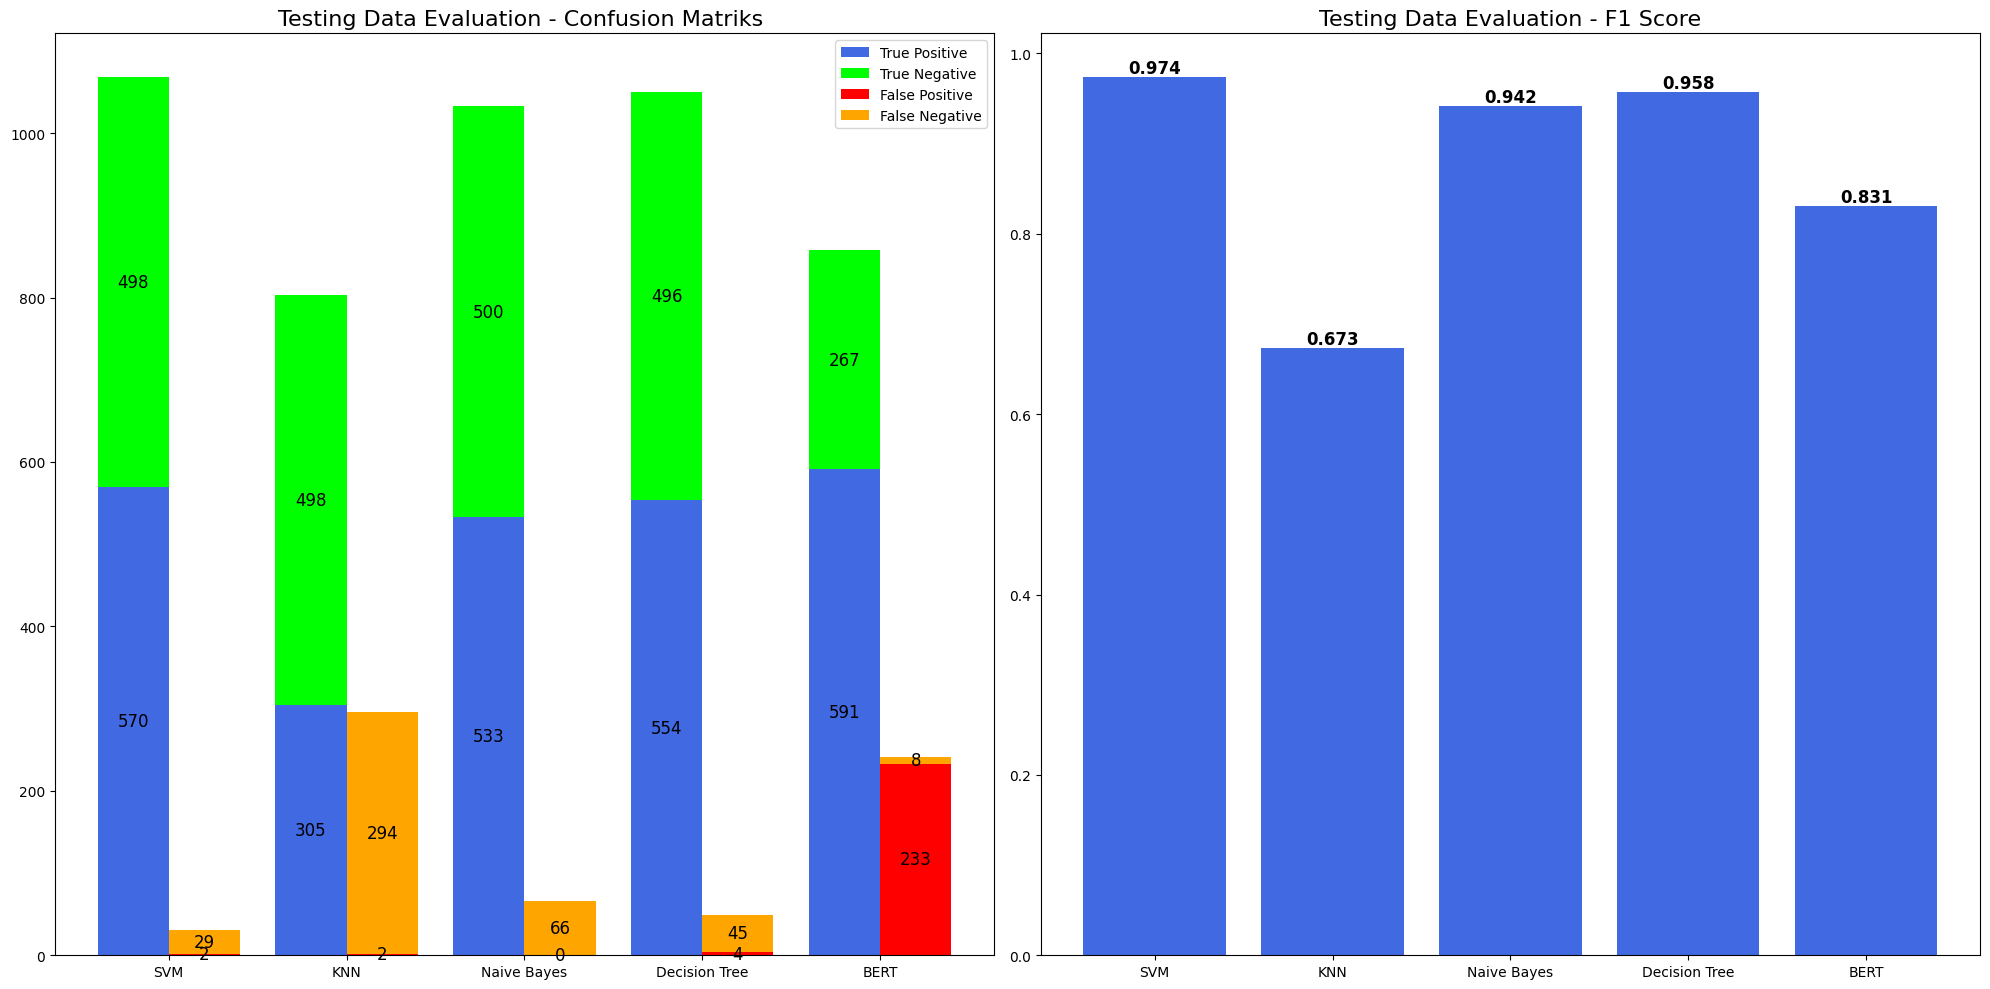

In [7]:
labels = test_data_eval["Model"]
x = np.arange(len(labels)) 
width = 0.4 
# Create a figure and an array of axes objects
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
models=['SVM','KNN','Naive Bayes', 'Decision Tree', 'BERT']
# Set the title for the second subplot
ax[1].set_title('Testing Data Evaluation - F1 Score', fontsize=16)

# Plot the bar chart on the second subplot
bars = ax[1].bar(models, test_data_eval["F1-Score"], color='royalblue', label='F1-Score')

# Add values on top of bars
for bar in bars:
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', 
               ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')


tp = test_data_eval["TP"]
fp = test_data_eval["FP"]
fn = test_data_eval["FN"]
tn = test_data_eval["TN"]

# Stacked TP & TN
bars_tp = ax[0].bar(x - width/2, tp, width, label='True Positive', color='royalblue')
bars_tn = ax[0].bar(x - width/2, tn, width, bottom=tp, label='True Negative', color='lime')

# Stacked FP & FN
bars_fp = ax[0].bar(x + width/2, fp, width, label='False Positive', color='red')
bars_fn = ax[0].bar(x + width/2, fn, width, bottom=fp, label='False Negative', color='orange')

# Add labels, title, and legend
#ax[0].set_xlabel("Model", fontsize=14)
#ax[0].set_ylabel("Count", fontsize=14)

ax[0].set_title("Testing Data Evaluation - Confusion Matriks ", fontsize=16)
ax[0].set_xticks(x)
#ax[0].set_yticks()
ax[0].set_xticklabels(models)
ax[0].legend()

def add_labels(bars, bottom=None):
    for bar in bars:
        height = bar.get_height()
        y_pos = bar.get_y() + height / 2  # Center the label vertically within the bar segment
        if bottom is not None:
            y_pos = bottom + height / 2  # Adjust for stacked bars
        ax[0].text(bar.get_x() + bar.get_width()/2, y_pos, f'{height}', 
                   ha='center', va='center', fontsize=12, color='black')

# Apply labels to each stack
for bars in [bars_tp, bars_tn, bars_fp, bars_fn]:
    add_labels(bars)
# Display the plot
plt.tight_layout()
plt.show()